In [1]:
from datasets import Dataset
from gpn.data import GenomeMSA
from gpn.msa.inference import run_inference
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from scipy.spatial.distance import cdist
from scipy.stats import zscore
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
SPLITS = [
    [str(i) for i in range(1, 23) if i % 2 == 1] + ["X"],
    [str(i) for i in range(1, 23) if i % 2 == 0] + ["Y"],
]
D = 768
features = [f"embedding_{i}" for i in range(D)]
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/gwas/matched"
SPLITS

[['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X'],
 ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']]

In [6]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_model = models[-1]


model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,0.992,-0.229947
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,2.697,-0.265800
2,1,3473193,A,G,1.000000,0.004888,True,-3.866422,-7.004,-1.000,-5.834,-7.358945
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,0.078,0.366593
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,0.796,0.051364
...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,1.983,-1.423862
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,0.389,0.327549
4595,9,137457837,C,A,0.002396,0.000404,False,-2.397935,-0.639,-0.999,-2.805,-9.272251
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,-0.517,-4.683803


In [7]:
V = pd.concat([
    V,
    pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{embedding_model}.parquet")
], axis=1)
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,...,165.098343,274.461639,30.080261,89.282715,35.790871,52.854183,81.442467,112.200142,46.461014,108.061310
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,...,71.808624,178.189682,77.942543,99.748047,51.746712,67.677635,94.293442,195.189713,47.118912,151.407135
2,1,3473193,A,G,1.000000,0.004888,True,-3.866422,-7.004,-1.000,...,85.656189,112.398033,108.442017,210.778168,111.393242,129.981659,193.077423,81.717682,112.536942,209.654205
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,...,78.824310,205.039612,65.752853,134.483780,47.590786,71.283264,77.642731,176.084274,49.058060,121.124336
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,...,84.506546,251.616379,52.411667,173.752396,51.429626,62.923546,41.570557,220.144379,77.021507,131.276062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,...,54.734184,260.125916,81.691231,143.298126,59.485828,67.351257,36.868748,231.001373,57.899296,149.295929
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,...,77.373245,632.852783,48.107620,270.782990,75.519180,81.984711,307.771484,341.421509,207.751083,86.728790
4595,9,137457837,C,A,0.002396,0.000404,False,-2.397935,-0.639,-0.999,...,89.710037,91.894783,71.581818,99.526917,84.494965,136.120209,191.746445,92.237320,88.774384,182.365601
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,...,64.028519,169.699677,55.682816,126.009613,70.419205,100.130997,45.952930,247.000137,156.170654,86.073227


In [8]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [9]:
enformer = pd.read_parquet("../../results/enformer/merged.correct_ref_alt.parquet")
enformer

,chrom,pos,ref,alt,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,10642,G,A,-4.500000,-0.130371,-0.044769,G
1,1,11008,C,G,-3.861328,-0.087769,-0.032928,C
2,1,11012,C,G,-12.265625,-0.251465,-0.085571,C
3,1,11063,T,G,-6.304688,-0.156494,-0.029846,T
4,1,13110,G,A,-1.482422,-0.043243,-0.009705,G
...,...,...,...,...,...,...,...,...
25273048,22,50802392,C,T,-0.846680,-0.020538,-0.006084,C
25273049,22,50802857,T,G,-2.433594,-0.051331,-0.017822,T
25273050,22,50802958,C,G,-3.312500,-0.091431,-0.012917,C
25273051,22,50805735,A,G,-2.132812,-0.042755,-0.004509,A


In [10]:
V = V.merge(enformer, on=cols, how="left")
models += [
    "Enformer_l2",
    #"Enformer_l1",
    #"Enformer_linf",
]
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,...,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,...,35.790871,52.854183,81.442467,112.200142,46.461014,108.061310,-0.666504,-0.022095,-0.004440,G
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,...,51.746712,67.677635,94.293442,195.189713,47.118912,151.407135,-3.716797,-0.123291,-0.022949,T
2,1,3473193,A,G,1.000000,0.004888,True,-3.866422,-7.004,-1.000,...,111.393242,129.981659,193.077423,81.717682,112.536942,209.654205,NaN,NaN,NaN,NaN
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,...,47.590786,71.283264,77.642731,176.084274,49.058060,121.124336,-9.804688,-0.364258,-0.094421,A
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,...,51.429626,62.923546,41.570557,220.144379,77.021507,131.276062,-0.505859,-0.013329,-0.001872,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,...,59.485828,67.351257,36.868748,231.001373,57.899296,149.295929,-0.307861,-0.008759,-0.002554,A
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,...,75.519180,81.984711,307.771484,341.421509,207.751083,86.728790,-0.279053,-0.008392,-0.003040,A
4595,9,137457837,C,A,0.002396,0.000404,False,-2.397935,-0.639,-0.999,...,84.494965,136.120209,191.746445,92.237320,88.774384,182.365601,NaN,NaN,NaN,NaN
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,...,70.419205,100.130997,45.952930,247.000137,156.170654,86.073227,-2.115234,-0.073059,-0.018829,C


In [11]:
V.dropna(subset=models, inplace=True)
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,...,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,...,35.790871,52.854183,81.442467,112.200142,46.461014,108.061310,-0.666504,-0.022095,-0.004440,G
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,...,51.746712,67.677635,94.293442,195.189713,47.118912,151.407135,-3.716797,-0.123291,-0.022949,T
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,...,47.590786,71.283264,77.642731,176.084274,49.058060,121.124336,-9.804688,-0.364258,-0.094421,A
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,...,51.429626,62.923546,41.570557,220.144379,77.021507,131.276062,-0.505859,-0.013329,-0.001872,A
5,1,8447713,G,A,0.990299,0.208465,True,0.426309,0.417,-0.000,...,58.836277,68.765419,79.234848,282.480652,67.180313,131.892883,-2.691406,-0.087952,-0.016724,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,9,123408251,G,C,0.003173,0.141907,False,0.208771,0.779,-0.000,...,53.239246,61.563457,51.112675,249.975281,51.520966,148.919922,-0.862793,-0.026382,-0.007500,G
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,...,59.485828,67.351257,36.868748,231.001373,57.899296,149.295929,-0.307861,-0.008759,-0.002554,A
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,...,75.519180,81.984711,307.771484,341.421509,207.751083,86.728790,-0.279053,-0.008392,-0.003040,A
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,...,70.419205,100.130997,45.952930,247.000137,156.170654,86.073227,-2.115234,-0.073059,-0.018829,C


In [12]:
def train_predict_best_inner_product(V_train, V_test):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            class_weight="balanced",
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=1000,
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    if C == Cs[0] or C == Cs[-1]:
        raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = [
    ("Best inner product", train_predict_best_inner_product),
    ("LR(inner products)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features)),
    ("LR(inner products + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["Enformer_l2"])),
    #("LR(inner products + LLR)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA"])),
    #("LR(inner products + LLR + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA", "Enformer_l2"])),
]

for split in SPLITS:
    print(split)
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        print(model_name)
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])

['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X']
Best inner product


100%|██████████| 768/768 [00:01<00:00, 684.34it/s]


LR(inner products)


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

LR(inner products + Enformer)


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']
Best inner product


100%|██████████| 768/768 [00:01<00:00, 744.69it/s]


LR(inner products)


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

LR(inner products + Enformer)


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [13]:
n_pos, n_neg = V.label.sum(), (~V.label).sum()
subtitle = f"n={n_pos} vs. {n_neg}"

results = []
for m in models:
    results.append([m, roc_auc_score(V.label, -V[m])])
results = pd.DataFrame(results, columns=["Model", "AUROC"])
results

,Model,AUROC
0,CADD,0.661918
1,phyloP-100-vertebrates,0.624383
2,phastCons-100-vertebrates,0.578781
3,phyloP-241-mammals,0.642170
4,GPN-MSA,0.648285
5,Enformer_l2,0.725975
6,Best inner product,0.751499
7,LR(inner products),0.764250
8,LR(inner products + Enformer),0.772967


In [14]:
#results.to_parquet("results_gwas_0.9.parquet", index=False)
#results.to_csv("results_gwas.csv", index=False)

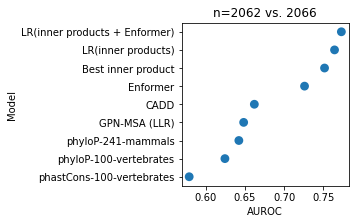

In [15]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("AUROC", ascending=False).replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);